DEEPALI DAGAR
BTECH CSE

INTERNSHIP TASK

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

# **Loading Dataset**

In [40]:
fraud = pd.read_csv('/content/Fraud.csv')





In [41]:
print(fraud.head())
print(fraud.shape)

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0
(3384999, 11)


In [42]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3384999 entries, 0 to 3384998
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 284.1+ MB


## **Data cleaning including missing values, outliers and multi-collinearity.**

Check missing values

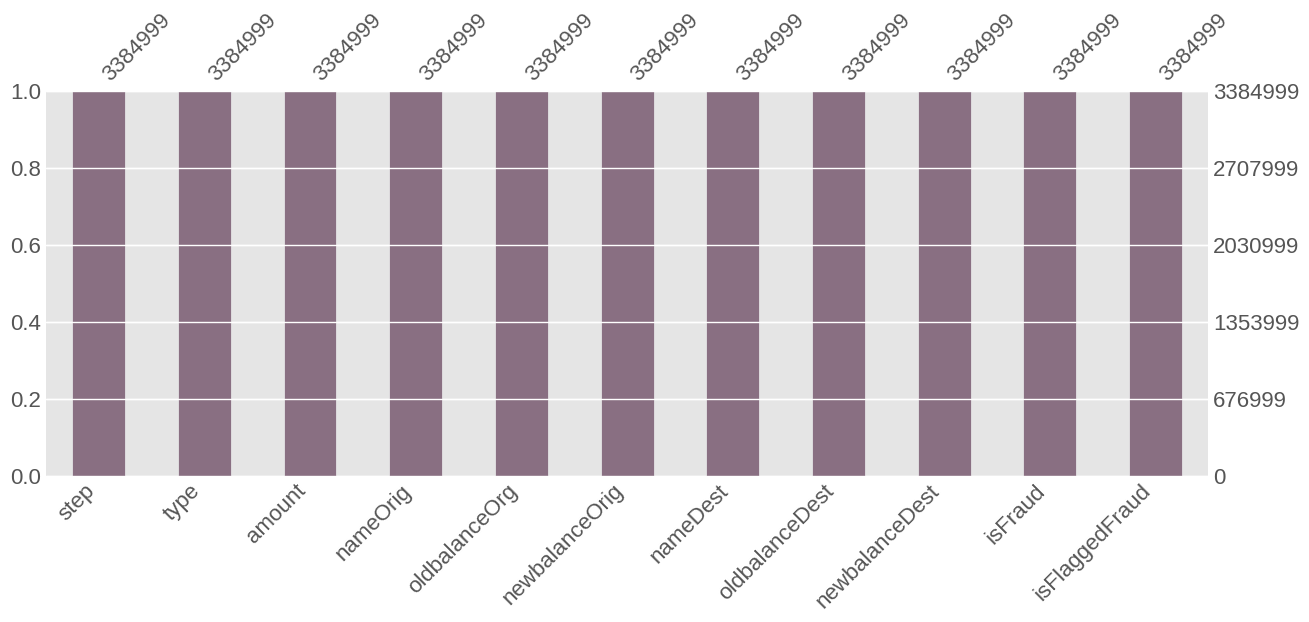

In [43]:
plt.figure(figsize = (15, 8))
msno.bar(fraud, figsize = (15,5), sort = 'ascending', color = "#896F82")
plt.show()

Check duplicate values

In [44]:
fraud.duplicated().sum()

0

No duplicate value in dataset

checking typo name of column

In [45]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [47]:
#I changed column names'nameOrigin','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest', 'isFraud'
fraud = fraud.rename(columns = {'nameOrig' : 'origin', 'oldbalanceOrg' : 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'destination', 'oldbalanceDest' : 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance', 'isFraud' : 'isfraud'})
fraud.columns

Index(['step', 'type', 'amount', 'origin', 'sender_old_balance',
       'sender_new_balance', 'destination', 'receiver_old_balance',
       'receiver_new_balance', 'isfraud', 'isFlaggedFraud'],
      dtype='object')

Drop no essential columns -> ‘step’ and ‘isFlaggedFraud’

In [48]:
fraud = fraud.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

To do easy analysis, I will move column 'destination' near ‘origin’ column

In [49]:
cols = fraud.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('destination')))
fraud = fraud[cols]

Checking all column lengths

In [67]:
column_lengths = {column: len(fraud[column]) for column in fraud.columns}

# Print the column lengths
for column, length in column_lengths.items():
    print(f"Column '{column}' has length: {length}")

Column 'type' has length: 3384999
Column 'amount' has length: 3384999
Column 'origin' has length: 3384999
Column 'destination' has length: 3384999
Column 'sender_old_balance' has length: 3384999
Column 'sender_new_balance' has length: 3384999
Column 'receiver_old_balance' has length: 3384999
Column 'receiver_new_balance' has length: 3384999
Column 'isfraud' has length: 3384999


In [50]:
# Check Final Dataset
fraud.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


# **EXPLORATORY DATA ANALYSIS**

**We will make a barplot to see fraud and non fraud transactions in different type of transactions**

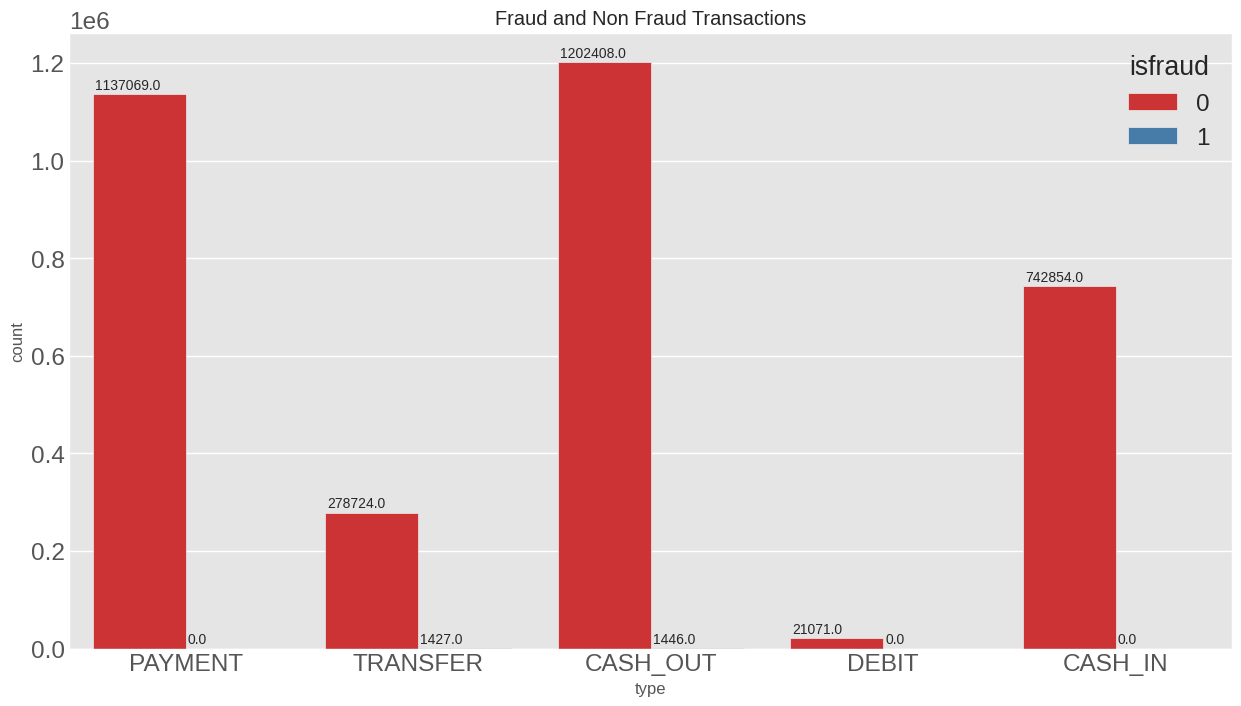

In [51]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = fraud, x = "type", hue="isfraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

**Checking the origin from where the transactions were made.**



In [52]:
transfer_fraud = fraud[((fraud['type']=='TRANSFER') & fraud['isfraud']==1)]
transfer_fraud['origin'].value_counts()

C1305486145    1
C975058065     1
C1945733096    1
C139567724     1
C1145874885    1
C1173597457    1
C1224347529    1
C167000923     1
C220889804     1
C622490191     1
C1225444134    1
C822440427     1
C607841205     1
C1454479269    1
C287179256     1
C1185526711    1
C2057236817    1
C742560107     1
C1404051898    1
C660401037     1
C763158589     1
C612440112     1
C499413300     1
C847645948     1
C1786873519    1
C381361852     1
C1059048177    1
C269586654     1
C1987163387    1
C386692409     1
C377226285     1
C627887471     1
C1302526975    1
C1042347270    1
C1835704513    1
C548545362     1
C2027508914    1
C1324987757    1
C739431473     1
C662766800     1
C533125295     1
C99753762      1
C664235460     1
C840664227     1
C166998225     1
C1027432342    1
C1371017446    1
C364430080     1
C1616917685    1
C590755759     1
C1764461949    1
C962450896     1
C814345778     1
C881291661     1
C865731380     1
C639037502     1
C1744142327    1
C1274910960    1
C752627210    

**Checking the destination from where the transactions were cashed out.**

In [62]:
cash_out_fraud = fraud[(fraud['type'] == 'CASH_OUT') & (fraud['isfraud'] == 1)]
cash_out_fraud['destination'].value_counts()


C644163395     2
C1981613973    2
C967226405     2
C803116137     2
C200064275     2
C1013511446    2
C185805228     2
C1656789626    1
C1347472124    1
C45760834      1
C2116650207    1
C505864940     1
C383086012     1
C386229497     1
C378717851     1
C755223579     1
C750943234     1
C1384358824    1
C941219258     1
C1478839564    1
C1006926522    1
C1776769189    1
C1814696637    1
C610130308     1
C2093453750    1
C354225366     1
C1545423847    1
C434428379     1
C1861630818    1
C900560128     1
C2034180207    1
C350037607     1
C856044772     1
C161212060     1
C99354775      1
C1075348177    1
C1543135091    1
C12493912      1
C1865178469    1
C171474212     1
C414783966     1
C1403933655    1
C500640535     1
C1040401356    1
C1430125468    1
C1877485591    1
C943512909     1
C1897800945    1
C8248650       1
C1571144443    1
C1610140948    1
C247089725     1
C2113246492    1
C366537960     1
C821758097     1
C1591408637    1
C1196198165    1
C1443276157    1
C966258334    

**Checking if the transfer and receiving account were same.**

In [68]:
fraud_trans = fraud[fraud['isfraud'] == 1]
valid_trans = fraud[fraud['isfraud'] == 0]

trans_transfer = fraud[fraud['type'] == 'TRANSER']
trans_cashout = fraud[fraud['type'] == 'CASH_OUT']

print('Has the receiving account used for cashing out?')
trans_transfer.destination.isin(trans_cashout.origin).any()

Has the receiving account used for cashing out?


False

This means that the transactions account used for Receiving and Sending was not Same in case of Fraud transactions.

The fraud transactions were generally from Customer to Customer.

# **Feature Engineering**

 I will create new dataset with name ‘data’ from copying dataset ‘fraud’.
 In dataset ‘name’, I created a column named ‘type2’ which  will include transaction code types, ‘C’ for Customer and ‘M’ for Merchant.
I will extract this code from the origin and destination columns.

In [69]:
data = fraud.copy()
data['type2'] = np.nan
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('C'), 'type2'] = 'CC'
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('M'), 'type2'] = 'CM'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MC'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MM'


Changing the column position for easy use

In [70]:
cols = data.columns.tolist()
new_position = 1

cols.insert(new_position, cols.pop(cols.index('type2')))
data = data[cols]

Dropping the irrelevant columns -> ‘Origin’ and ‘Destination’

In [71]:
data.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)
data.head()

,type,type2,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,CC,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,CC,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.0,0.0,0


Now we are going to see the number of fraud and valid transactions according to the type 2

In [72]:
fraud_trans = data[data['isfraud'] == 1]
valid_trans = data[data['isfraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 CC    2873
Name: type2, dtype: int64 

Number of valid transactions according to type are below:
 CC    2245057
CM    1137069
Name: type2, dtype: int64




1.   Number of fraud transactions according to type are below: CC 2873
2.   Number of valid transactions according to type are below: CC 2245047 AND CM 1137069



# **Data Visualization**

Text(0.5, 1.0, 'Valid')

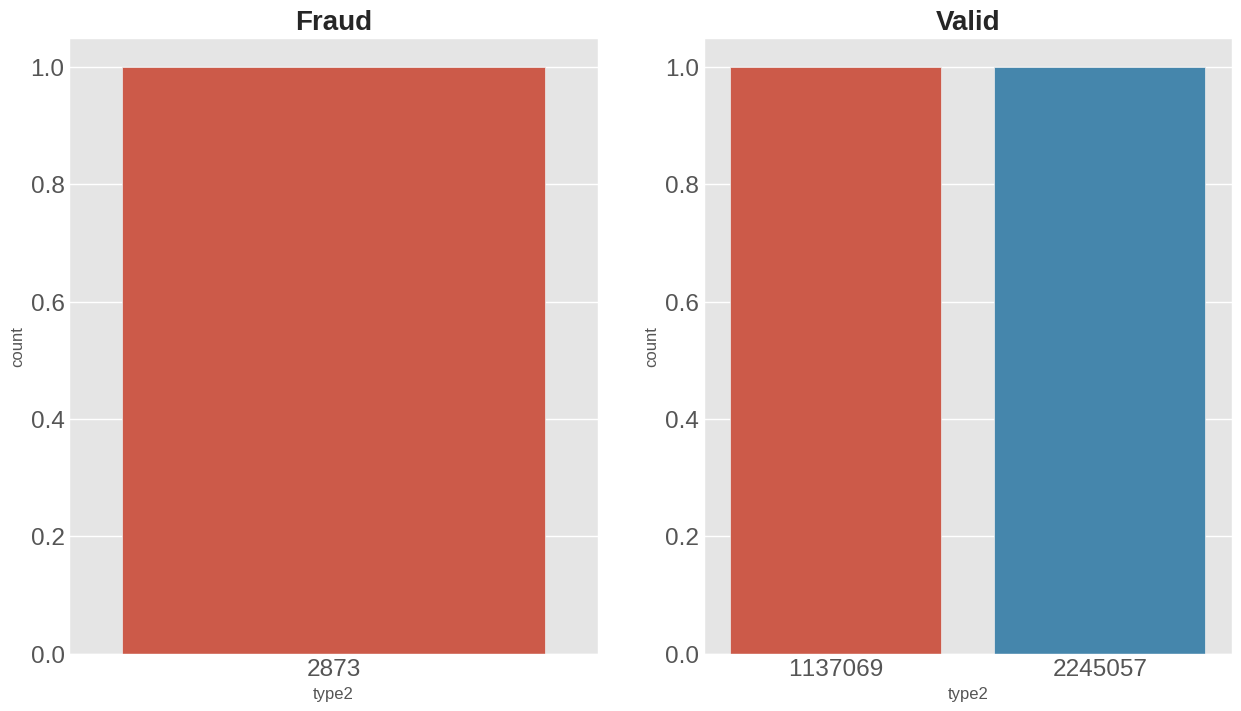

In [73]:
fr = fraud_trans.type2.value_counts()
va = valid_trans.type2.value_counts()
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.countplot(x = fr)
plt.title('Fraud',fontweight="bold", size=20)
plt.subplot(1,2,2)
sns.countplot(x = va)
plt.title('Valid',fontweight="bold", size=20)

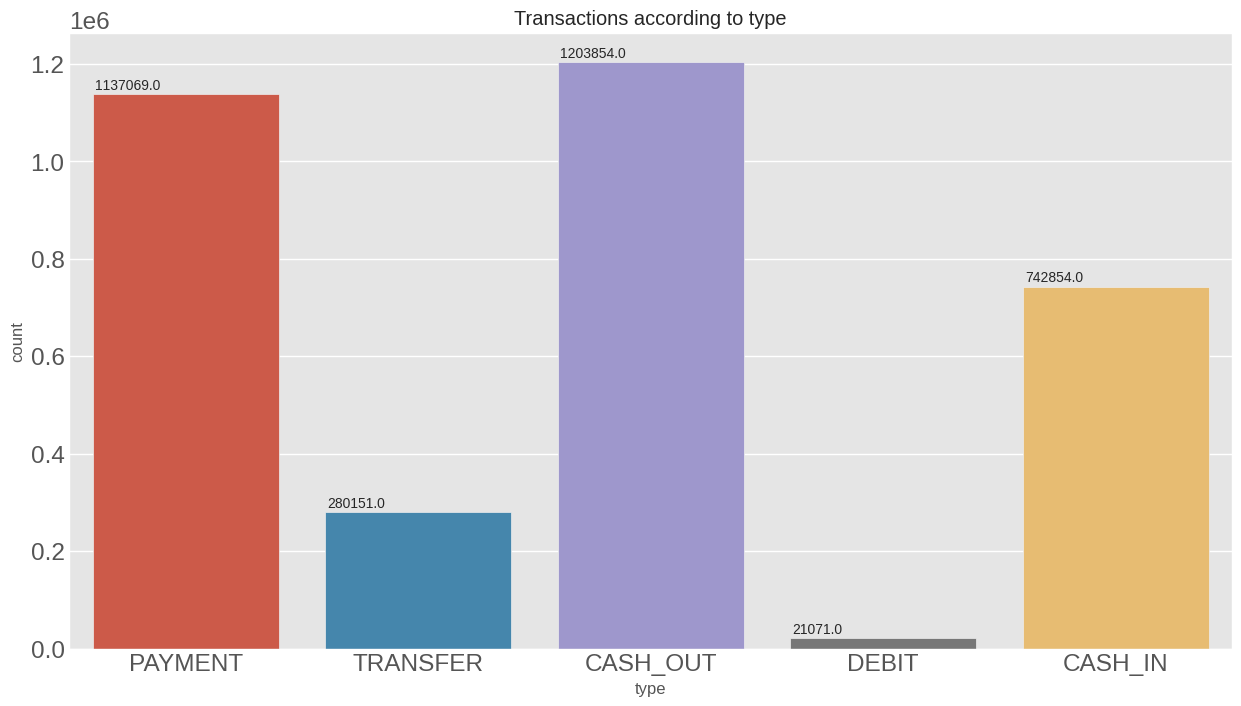

In [74]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type")
plt.title('Transactions according to type')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))


The first two visualizations contains the number of transactions according to the type of transaction, sender and reciever type.

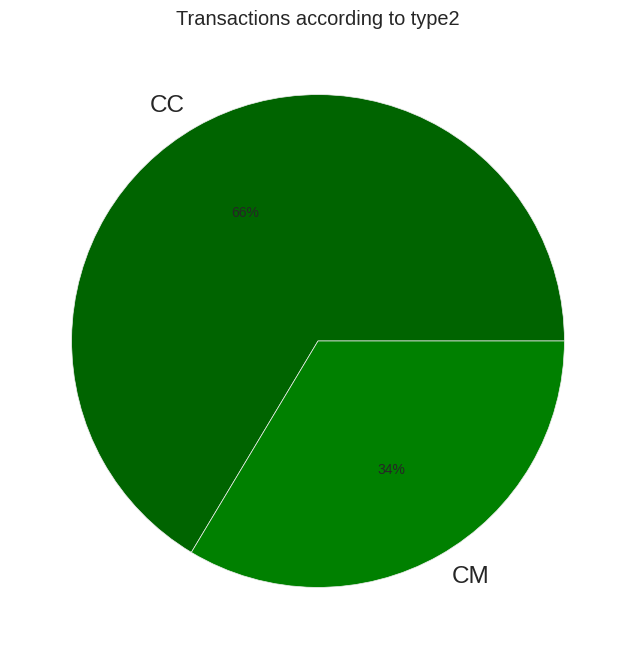

In [78]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000']
plt.pie(data.type2.value_counts().values,labels=data.type2.value_counts().index, colors = colors,  autopct='%.0f%%')
plt.title("Transactions according to type2")
plt.show()


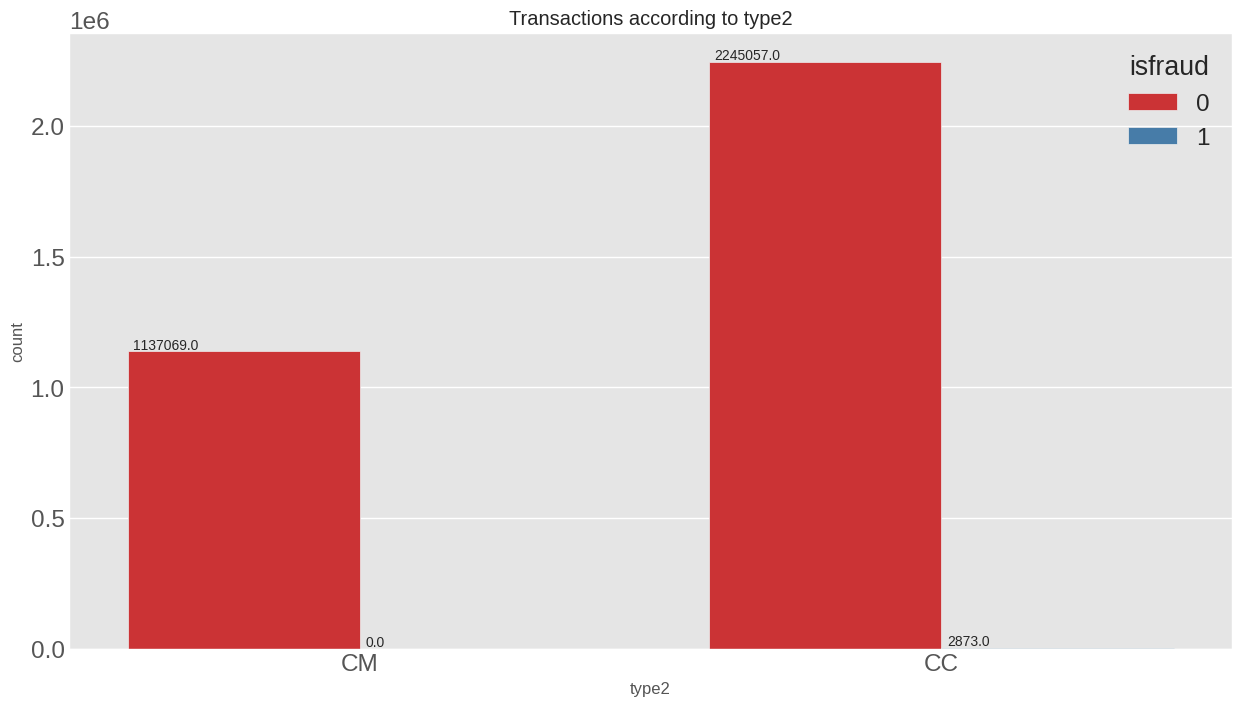

In [76]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type2", hue="isfraud", palette = 'Set1')
plt.title('Transactions according to type2')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))



1.  Most common transaction type used for transactions = CASH_OUT.
2.   Least common transaction type used for transactions = DEBIT.
3. Most of the transactions done were Customer to Customer.



# **Data Preprocessing**

I’ll use dummy hot encoding as the columns does not have a specific order.

In [79]:
data = pd.get_dummies(data, prefix = ['type', 'type2'], drop_first = True)


Split the dataset into training and testing part and then do the standardization.



In [80]:
X = data.drop('isfraud', 1)
y = data.isfraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = data.isfraud)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# **Model Building**

We will use 4 ML models and train them. Later we will append each model into the list.

In [86]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
lgbm = LGBMClassifier(boosting_type = 'gbdt',objective = 'binary', random_state = 8888)
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
logreg = LogisticRegression(solver = 'liblinear', random_state = 42)


rfc.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgbr.fit(X_train, y_train)
logreg.fit(X_train, y_train)

classifiers = []
classifiers.append(rfc)
classifiers.append(lgbm)
classifiers.append(xgbr)
classifiers.append(logreg)


Let’s do the prediction and find out both Accuracy and Area Under Curve (AUC) of each model.



In [87]:
accuracy_list = []
auc_list = []

for classifier in classifiers:
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))

accuracy_dict = {}
auc_dict = {}
for i in range(4):
    key=['Random Forest', 'Light GBM', 'XGBoost','LR'][i]
    accuracy_dict[key] = accuracy_list[i]
    auc_dict[key] = auc_list[i]

accuracy_dict_sorted = dict(sorted(accuracy_dict.items(), key = lambda item: item[1]))
auc_dict_sorted = dict(sorted(auc_dict.items(), key = lambda item: item[1]))

create a functions for the visualization part.

In [88]:
def px_bar(x,y,text,title,color,color_discrete_sequence):
    return px.bar(x = x, y = y, text = text, title = title, color = color, color_discrete_sequence=color_discrete_sequence)

In [90]:
fig = px_bar(list(accuracy_dict_sorted.keys()), list(accuracy_dict_sorted.values()), np.round(list(accuracy_dict_sorted.values()),3), 'Accuracy score of each classifiers', list(accuracy_dict_sorted.keys()), px.colors.sequential.matter)
for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

In [91]:
fig = px_bar(list(auc_dict_sorted.keys()), list(auc_dict_sorted.values()), np.round(list(auc_dict_sorted.values()),3), 'AUC score of each classifiers', list(auc_dict_sorted.keys()), px.colors.sequential.matter)

for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

**We trained 4 algorithms and Random Forest performed the best among them. **

# **Model Evaluation**

Let’s train our best model once again. -> Random Forest

In [92]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)[:,1]

In [93]:
print(classification_report(y_test, rfc_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1014638
       Fraud       0.97      0.73      0.83       862

    accuracy                           1.00   1015500
   macro avg       0.98      0.87      0.92   1015500
weighted avg       1.00      1.00      1.00   1015500



Showing the AUC below to show Randome Forest performance.

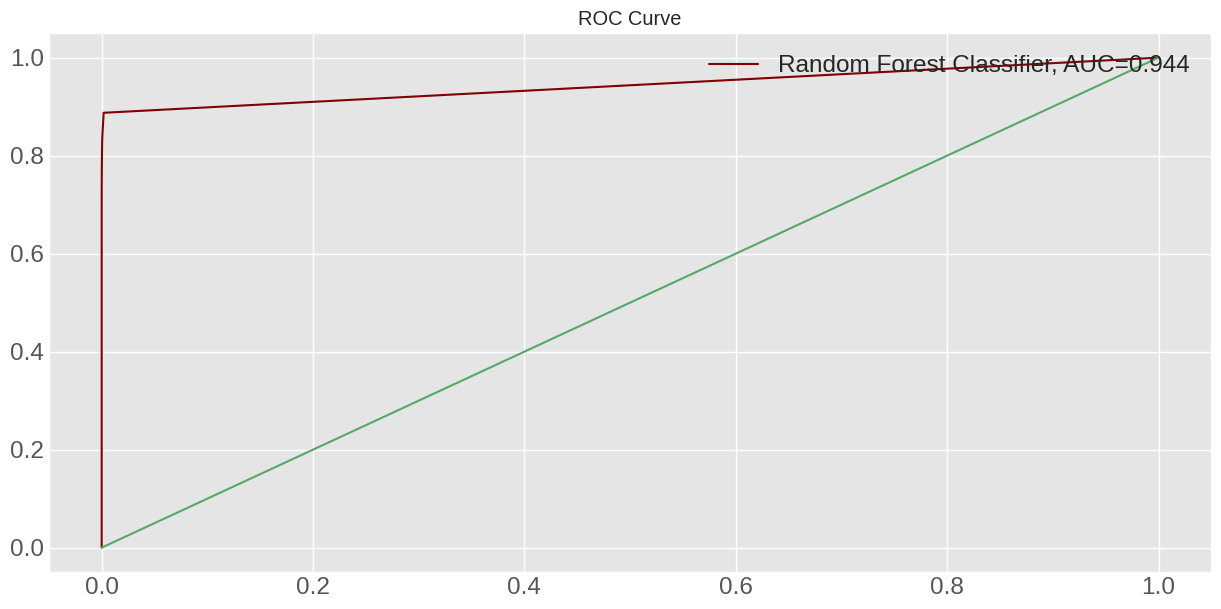

In [94]:
fpr, tpr, temp = roc_curve(y_test, rfc_pred_proba)
auc = round(roc_auc_score(y_test, rfc_pred_proba),3)
plt.figure(figsize=(15,7))
plt.plot(fpr,tpr,label='Random Forest Classifier, AUC='+str(auc),linestyle='solid',color='#800000')
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('ROC Curve')
plt.legend(loc='upper right')

## **Conclusion**

The total number of fraud transactions were 2873 out of 3384999 transactions. These fraud transactions were either CASH_OUT or DEBIT and were made from a Customer to Customer account. The value of reacall is 0.8, it mean that the model able detection true positife about 80% from all of data who give value fraud. And It gave the AUC score of 0.9, this indicated that the model has a highly effective ability to distinguish between positive and negative classes. It means that the model tends to assign higher scores to samples from the positive class compared to samples from the negative class. In the application context, a model with an AUC of 0.9 is considered to have a very strong predictive capability.



## **DOCUMENTATION**

### **1.Describe your fraud detection model in elaboration.**

1. Data Collection: The first step is i have collected relevant data from various sources, such as transactions,type, user behavior, amounts, origin, destination, sender and reciever old/new balance, fraud and non fraud transactions.

EXPLORATORY DATA ANALYSIS

2. Feature Engineering: In this step, meaningful features are extracted from the raw data to improve the model's performance. Domain knowledge plays a crucial role in identifying relevant features and unrelevant features are removed.

3. Data Visualization: Visualize the data using graphs, charts, and plots to gain a better understanding of the data distribution, patterns, and relationships.

4. Data Preprocessing: Once the data is collected, it needs to be preprocessed to prepare it for analysis. This includes tasks such as cleaning the data, handling missing values, outliers, encoding categorical variables, and normalizing or scaling numerical features.

4. Model Selection: The choice of model depends on the specific requirements, the nature of the data, and the desired trade-offs between accuracy and interpretability. I have selected 4 ML models which are
- Random forests Classifier
- Light gradient-boosting machine model(LGBM)
- XGBoost, Extreme gradient boosting
- Logistic Regression

5. Model Training: The selected model is trained using labeled data, where fraudulent and non-fraudulent instances are labeled.

6. Model Evaluation: The trained model is evaluated using evaluation metrics such as accuracy(AUC), precision, recall, and F1-score. It is essential to assess the model's performance on both fraudulent and non-fraudulent instances to ensure a good balance between false positives and false negatives.

7. Model Deployment: Once the model is trained and evaluated, it can be deployed into a production environment where it can process real-time data and make predictions. The model can flag suspicious activities for further investigation or trigger automated actions to prevent fraudulent transactions.

8. Model Monitoring and Improvement: Monitoring involves tracking the model's accuracy, detecting concept drift, and retraining the model with new data periodically.



### **2. How did you select variables to be included in the model?**

Variable selection is done to choose the most relevant and informative variables to include in a predictive model. It improves model performance, reduce overfitting, enhance interpretability, and reduce computational complexity.

1. I identified variables that are known to be directly related to the target variable or have a strong theoretical basis to be included in the model.

2. Also i trained a machine learning model on the set of variables and examine the coefficients or feature importance scores to identify the most influential variables.

### **3. Demonstrate the performance of the model by using best set of tools.**

I used Evaluation Metrics:

1. Accuracy: Calculate the percentage of correctly classified instances.

2. Precision: Measure the proportion of true positive predictions out of the total predicted positives and distinguish between positive and negative classes.

And

For tree-based models like Random Forest, LGBM, and XGBoost, you can examine the feature importance scores to understand which variables have the most significant impact on the model's predictions.

### **3. What are the key factors that predict fraudulent customer?**

1. Abnormal transaction patterns: Look for unusual transaction amounts, frequency, or patterns that deviate significantly from the norm.

2. Analyze the IP address and geolocation data associated with customer transactions. If the same customer is doing fraud transaction to another customer with same IP address.

3. Explore the connections between customers and their networks. Identify any suspicious relationships.

4. Utilize external data sources, such as fraud databases, blacklists, or public records, to identify customers with a history of fraudulent behavior.


### **4. Do these factors make sense? If yes, How? If not, How not?**

Yes, these factors make sense in the context of fraud detection because while these factors provide valuable insights for fraud detection. Fraudulent activities often involve unusual transaction behavior, such as large amounts, frequent transactions, or patterns that deviate from normal customer behavior. By identifying these anomalies, it becomes possible to flag potentially fraudulent transactions.

### **5. What kind of prevention should be adopted while company update its infrastructure?**


1. Security Assessment: Conduct a comprehensive security assessment of the existing infrastructure to identify potential vulnerabilities and weaknesses.

2. Secure Configuration: Ensure that the updated infrastructure is configured securely.

3. Strong Authentication and Access Controls: Implement strong authentication mechanisms

4. Data Encryption: Encrypt sensitive data at rest and in transit to protect it from unauthorized access.

5. Regular Security Audits: Conduct periodic security audits to assess the effectiveness of the security measures and infrastructure updates.

### **6. Assuming these actions have been implemented, how would you determine if they work?**

To determine the effectiveness of the implemented actions in securing the infrastructure, you can employ several methods and metrics.

1. Security Metrics: Define and track specific security metrics to measure the effectiveness of the implemented actions.

2. Monitoring and Threat Detection: Continuously monitor the infrastructure using security monitoring tools and threat intelligence feeds.

3. Security Audits: Audits help identify any gaps or deficiencies in the security controls and provide recommendations for remediation.